### Import Statements

In [1]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchvision.transforms import functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
!nvidia-smi

Wed Nov  6 14:09:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.01             Driver Version: 535.216.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  | 00000000:3B:00.0 Off |                    0 |
| N/A   21C    P0              32W / 250W |  13067MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /home/junhokim/code


In [4]:
# If using a CUDA device, move the model to GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    # model.to(device)
else:
    device = torch.device("cpu")

### Pretrained PyTorch Faster R-CNN

Faster R-CNN is an object detection model that uses a box predictor for detecting objects within regions of interest (ROIs). This predictor is responsible for both bounding box regression (localizing the objects) and classification (classifying the objects in the detected boxes).

In Faster R-CNN, the box_predictor is part of the roi_heads, which is responsible for taking the features extracted from the backbone and making predictions.

model.roi_heads.box_predictor.cls_score refers to the classification head that outputs the scores for different classes (in this case, background and building).
By modifying model.roi_heads.box_predictor, you are replacing the entire box predictor, which includes the logic for both classification and bounding box regression. This is why you access the predictor through roi_heads rather than simply replacing a single fully connected layer.

### Build Dataset

In [5]:
# Check directory existence
data_dir = '/scratch/user/junhokim/data/'
folders = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]
print(folders)

['Checkpoints', 'BEAUTY1.0_COCOLike', 'NOAA_Sample']


In [6]:
beauty_dir = data_dir + "BEAUTY1.0_COCOLike/Split0/JPEGImages"
print(beauty_dir)
print(os.path.isdir(beauty_dir))

/scratch/user/junhokim/data/BEAUTY1.0_COCOLike/Split0/JPEGImages
True


In [7]:
import random
import json

image_dir = "/home/junhokim/code/image.json"
annotation_dir = "/home/junhokim/code/annotation.json"

with open(image_dir, 'r') as images:
    image_data = json.load(images)

with open(annotation_dir, 'r') as annotations:
    annotation_data = json.load(annotations)

if isinstance(image_data, dict):
    print("Image Data Type: Json, Dictionary\n")
    for key, val in image_data.items():
        # print(f"{key}: {val}\n")
        print(f"{key}\n")
        print(f"\"{key}\" Length: {len(image_data[key])}\n") # 4769
else:
    print("Error: Image Data not Json\n")

if isinstance(annotation_data, dict):
    print("Annotation Data Type: Json, Dictionary\n")
    for key, val in annotation_data.items():
        print(f"{key}\n")
        # print(f"{key}: {val}")
        print(f"\"{key}\" Length: {len(annotation_data[key])}\n") # 9749
else:
    print("Error: Annotation Data not Json\n")

Image Data Type: Json, Dictionary

images

"images" Length: 4769

Annotation Data Type: Json, Dictionary

annotations

"annotations" Length: 9747



In [12]:
# new_annotation = "/home/junhokim/code/new_annotation.json"
# original_annotation = annotation_data

# reorganized_data = {}
# for key, val in original_annotation.items():
#     if key == "annotations":
#         print("Found Annotations")
#         annots = original_annotation[key]
#         for ann in annots:
#             new_id = ann["image_id"]
#             new_bbox = ann["bbox"]
#             reorganized_data.setdefault(new_id, []).append(new_bbox)

# print(f"New Annotation Length: {len(reorganized_data)}\n") # 4769

In [11]:
# with open(new_annotation, 'w') as new_annotation:
#     json.dump(reorganized_data, new_annotation, indent=2)

# print("Data reorganized and saved to new JSON file successfully.")

Random Integer: s115

{'id': 115, 'file_name': 'Commercial_925.jpg', 'width': 512, 'height': 512}

Random Image ID: 115 | File Name: Commercial_925.jpg

{'1': [[239, 258, 116, 92], [32, 269, 162, 68], [374, 254, 138, 94]], '2': [[238, 1, 274, 337], [1, 44, 85, 187], [333, 289, 77, 46]], '3': [[133, 201, 152, 131]], '4': [[12, 1, 272, 365]], '5': [[22, 240, 284, 120], [342, 287, 170, 64]], '6': [[13, 243, 499, 108]], '7': [[164, 1, 275, 326], [1, 206, 92, 115], [110, 246, 50, 60]], '8': [[240, 275, 150, 70], [181, 289, 59, 52]], '9': [[153, 176, 130, 154], [1, 188, 163, 110], [291, 191, 141, 170]], '10': [[187, 234, 308, 116], [1, 189, 37, 85], [54, 231, 35, 48], [165, 220, 65, 44], [392, 207, 92, 34]], '11': [[60, 230, 295, 117], [335, 231, 177, 117], [1, 228, 92, 122]], '12': [[136, 212, 143, 137], [323, 138, 189, 246]], '13': [[1, 186, 263, 177], [342, 262, 170, 65]], '14': [[62, 253, 419, 67]], '15': [[15, 132, 291, 156], [387, 138, 125, 85]], '16': [[1, 152, 511, 347], [273, 162, 2

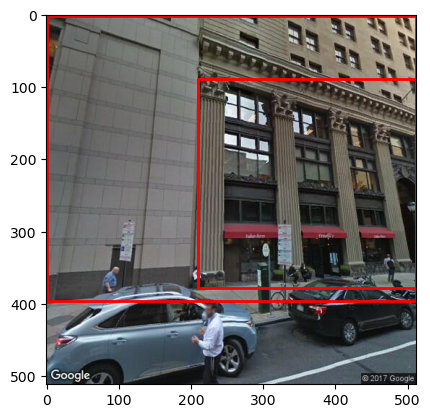

In [13]:
import random
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Bounding Box Sanity Check
def validate_bounding_box():
    # Random number
    random_int = random.randint(0, len(image_data["images"])-1)
    print(f"Random Integer: s{random_int}\n")

    # Base directory
    image_directory = beauty_dir

    # Get random image
    random_image = image_data["images"][random_int-1]
    print(random_image)
    print(f"\nRandom Image ID: {random_image['id']} | File Name: {random_image['file_name']}\n")

    with open("/home/junhokim/code/new_annotation.json", 'r') as annotations:
        bounding_box_data = json.load(annotations)
    
    print(bounding_box_data)
    bbox = bounding_box_data[str(random_int)]
    print("")
    print(bbox)

    # WHAT DO THESE COORDINATES MEAN? ALL COORDINATES OR WIDTH, LENGTH AS WELL?
    image_data_path = image_directory + "/" + random_image['file_name']
    print("")
    print(image_data_path)

    # Display the image
    image = Image.open(image_data_path)
    fig, ax = plt.subplots()
    ax.imshow(image)

    # Draw each bounding box in red
    for box in bbox:
        x, y, width, height = box  # Assuming the format [x, y, width, height]
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

    plt.show()

validate_bounding_box()

In [14]:
from PIL import Image, ImageDraw

def save_bbox_images():
    # Image Json File
    image_json = image_data

    # Base directory
    image_directory = beauty_dir

    # Save directory
    annotated_image_dir = data_dir + folders[0] + "/Split0/AnnotatedImages"
    os.makedirs(annotated_image_dir, exist_ok=True)

    print(annotated_image_dir)

    # Check if the directory exists
    if os.path.isdir(annotated_image_dir):
        print(f"Directory {annotated_image_dir} exists.")
    else:
        print(f"Directory {annotated_image_dir} was not created.")

    # Annotation Json File
    with open("/home/junhokim/code/new_annotation.json", 'r') as annotations:
        bounding_box_data = json.load(annotations)
    annotation_json = bounding_box_data

    # Debugging
    idx = 0
    print(len(image_json['images']))

    for image in image_json["images"]:
        # Extract image information
        id = image['id']
        file_name = image['file_name']
        width, height = image['width'], image['height']

        # Get Annotation
        bbox = annotation_json[str(id)]

        # Get image
        image_data_path = image_directory + "/" + file_name
        image = Image.open(image_data_path)

        # Convert to a format that allows drawing
        draw = ImageDraw.Draw(image)

        # Draw each bounding box in red
        for box in bbox:
            x, y, width, height = box  # Annotation format [x, y, width, height]
            draw.rectangle([(x, y), (x + width, y + height)], outline="red", width=2)

        # Save the modified image
        # output_path = annotated_image_dir + "/" + file_name
        output_path = os.path.join(annotated_image_dir, file_name)
        image.save(output_path)

        idx += 1
    
    print(idx)

    # List all entries and filter to include only files
    ann_list = [f for f in os.listdir(annotated_image_dir) if os.path.isfile(os.path.join(annotated_image_dir, f))]
    img_files = len(image_json['images'])
    if len(ann_list) == img_files:
        print(f"Number of files are the same.")

# save_bbox_images()

In [17]:
# Combine Json data
with open(image_dir, 'r') as images:
    image_data = json.load(images)

with open("/home/junhokim/code/new_annotation.json", 'r') as annotations:
    annotations_data = json.load(annotations)

# Combine data
combined_data = []
for image in image_data["images"]:
    image_id = str(image["id"])
    combined_data.append({
        "id": image_id,
        "file_name": image["file_name"],
        "width": image["width"],
        "height": image["height"],
        "annotations": annotations_data.get(image_id, [])
    })

# Save combined data
# beauty_data_dir = '/home/junhokim/code/beauty_data.json'
# with open(beauty_data_dir, 'w') as f:
#     json.dump(combined_data, f, indent=2)

In [19]:
# Split dataset into train, val, test
random.shuffle(combined_data)

# Define experiment id
experiment_id = "exp4"

# Define split ratios
train_ratio = 0.80
val_ratio = 0.10
test_ratio = 0.10

# Calculate split indices
train_count = int(len(combined_data) * train_ratio)
val_count = int(len(combined_data) * val_ratio)
test_count = int(len(combined_data) * test_ratio)

# Split the data
train_data = combined_data[:train_count]
val_data = combined_data[train_count:train_count + val_count]
test_data = combined_data[train_count + val_count:]

# Data directories
data_dir = f'/home/junhokim/code/datasplit_{experiment_id}'

# Create the directory if it doesn't exist
os.makedirs(data_dir, exist_ok=True)

# File paths
train_data_file = os.path.join(data_dir, 'train_data.json')
val_data_file = os.path.join(data_dir, 'val_data.json')
test_data_file = os.path.join(data_dir, 'test_data.json')

# Save each split
with open(train_data_file, 'w') as f:
    json.dump(train_data, f, indent=2)

with open(val_data_file, 'w') as f:
    json.dump(val_data, f, indent=2)

with open(test_data_file, 'w') as f:
    json.dump(test_data, f, indent=2)

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

class BuildingDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        # Load the data from the JSON file
        with open(json_file, 'r') as f:
            self.data = json.load(f)

        # Root directory for actual images
        self.root_dir = root_dir

        # Transformations (albumentations)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get image data and bounding box information
        image_data = self.data[idx]
        image_path = os.path.join(self.root_dir, image_data["file_name"])
        image = Image.open(image_path).convert("RGB")

        # Convert bounding boxes from [x, y, width, height] to [x_min, y_min, x_max, y_max]
        bboxes = []
        labels = []
        for bbox in image_data["annotations"]:
            x, y, width, height = bbox
            x_min, y_min = x, y
            x_max, y_max = x + width, y + height
            bboxes.append([x_min, y_min, x_max, y_max])
            labels.append(1)  # Assign label '1' to all buildings

        # Apply transformations
        if self.transform:
            transformed = self.transform(image=np.array(image), bboxes=bboxes, labels=labels)
            image = transformed["image"]
            bboxes = transformed["bboxes"]
            labels = transformed["labels"]

        # Convert bounding boxes and labels to tensors
        target = {
            "boxes": torch.tensor(bboxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64)
        }

        return image, target

/scratch/user/junhokim/.conda/envs/obj_detect/lib/python3.9/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [21]:
# With Augmentation
def get_transforms():
    train_transforms = A.Compose([
        A.Resize(512, 512),                             # Resize to 512x512
        A.HorizontalFlip(p=0.3),                        # Horizontal flip
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0),  # Color jitter
        A.GaussianBlur(blur_limit=(3, 5), p=0.1),       # Blurring
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.1),    # Gaussian noise
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.1),  # Brightness & Contrast
        A.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.1),  # Color shift
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalization
        ToTensorV2()                                    # Convert to tensor
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))   # Bounding boxes in [x_min, y_min, x_max, y_max]

    val_transforms = A.Compose([
        A.Resize(512, 512),                             # Resize
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

    return train_transforms, val_transforms

In [22]:
# import albumentations as A
# from albumentations.pytorch import ToTensorV2

# def get_transforms():
#     # Scaling only, without color normalization
#     train_transforms = A.Compose([
#         A.ToFloat(max_value=255.0),  # Convert to float and scale values to [0, 1]
#         ToTensorV2()  # Convert to tensor
#     ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

#     val_transforms = A.Compose([
#         A.ToFloat(max_value=255.0),  # Convert to float and scale values to [0, 1]
#         ToTensorV2()  # Convert to tensor
#     ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

#     return train_transforms, val_transforms

In [23]:
# Get transformations
train_transforms, val_transforms = get_transforms()

# Json files
root_dir = beauty_dir

# Initialize datasets
train_dataset = BuildingDataset(json_file=train_data_file, root_dir=root_dir, transform=train_transforms)
val_dataset = BuildingDataset(json_file=val_data_file, root_dir=root_dir, transform=val_transforms)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

In [24]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pretrained Faster R-CNN model
"""
freeze_all = False
unfreeze_box_pred = False
unfreeze_feature_extractor = False
"""

"""
# Model component freezer
# Freeze the entire model (including feature extractor)
if freeze_all:
    for param in model.parameters():
        param.requires_grad = False

# Unfreeze the box predictor (predicting bounding boxes and classes)
if unfreeze_box_pred:
    for param in model.roi_heads.box_predictor.parameters():
        param.requires_grad = True

# Unfreeze the feature extractor (backbone)
if unfreeze_feature_extractor:
    for param in model.backbone.parameters():
        param.requires_grad = True
"""

# Structure of Faster RCNN
# Backbone, Region Proposal Network, and ROI Heads (Alignment, Classification)
model_ft = fasterrcnn_resnet50_fpn(pretrained=True)

# Get the number of input features for the classifier
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one for 2 classes (background + building)
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_ft.to(device)

/scratch/user/junhokim/.conda/envs/obj_detect/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/scratch/user/junhokim/.conda/envs/obj_detect/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [25]:
import torch.optim as optim
from tqdm import tqdm

def train(net, num_epochs, learning_rate, weight_decay, checkpoint_dir):

    # Initialize the optimizer (SGD with momentum is commonly used for Faster R-CNN)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)

    # Define the learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

    # Variable to track the best validation loss
    best_val_loss = float('inf')  # Start with an infinitely high validation loss

    # Training and validation loop
    for epoch in range(num_epochs):
        print(f"---------- Epoch {epoch + 1}/{num_epochs} ----------")
        net.train()
        train_loss = 0
        tqdm_train = tqdm(train_loader, desc="Training", leave=False)

        for images, targets in tqdm_train:
            # Move data to the appropriate device
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            loss_dict = net(images, targets) # Regular python dictionary
            losses = sum(loss for loss in loss_dict.values()) # Pytorch Tensor type
            
            # Backward pass and optimize
            losses.backward() # Use Tensor type for optimization (cuda)
            optimizer.step()

            train_loss += losses.item() # Transforms tensor to float for type efficiency
            tqdm_train.set_postfix({"Batch Loss": losses.item()})
            
        # Average training loss for the epoch
        train_loss /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")

        # Validation phase
        net.eval()  # Set model to evaluation mode
        val_loss = 0
        tqdm_val = tqdm(val_loader, desc="Validation", leave=False)

        with torch.no_grad():
            for images, targets in tqdm_val:
                # Move data to the appropriate device
                images = [image.to(device) for image in images]
                targets = [{k: v.to(device) for k, v in target.items()} for target in targets]

                # Forward pass
                net.train()
                loss_dict = net(images, targets)
                net.eval()

                losses = sum(loss for loss in loss_dict.values())
                val_loss += losses.item()
                tqdm_val.set_postfix({"Batch Loss": losses.item()})

        # Average validation loss for the epoch
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")

        # Save checkpoint at the end of the epoch
        epoch_ckpt_path = os.path.join(checkpoint_dir, f"epoch_{epoch + 1}_model.pth")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
        }, epoch_ckpt_path)
        print(f"Checkpoint saved at {epoch_ckpt_path}")

        # Check if this is the best validation loss so far and save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_ckpt_path = os.path.join(checkpoint_dir, "best_model.pth")
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'val_loss': val_loss,
            }, best_ckpt_path)
            print(f"Best checkpoint saved at {best_ckpt_path} with validation loss: {best_val_loss:.4f}")

        # Update the learning rate
        lr_scheduler.step()
    
    print("\nTraining Complete!")

In [26]:
net = model_ft
num_epochs = 15
learning_rate = 0.005
weight_decay = 0.0005

# Checkpoint directory
checkpoint_dir = f'/scratch/user/junhokim/data/Checkpoints/checkpoints_{experiment_id}'
os.makedirs(checkpoint_dir, exist_ok=True)

train(net,
      num_epochs,
      learning_rate,
      weight_decay,
      checkpoint_dir)

---------- Epoch 1/15 ----------


Training Loss: 0.2712


Validation Loss: 0.2330
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_1_model.pth
Best checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/best_model.pth with validation loss: 0.2330
---------- Epoch 2/15 ----------


Training Loss: 0.2221


Validation Loss: 0.2173
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_2_model.pth
Best checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/best_model.pth with validation loss: 0.2173
---------- Epoch 3/15 ----------


Training Loss: 0.2034


Validation Loss: 0.2195
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_3_model.pth
---------- Epoch 4/15 ----------


Training Loss: 0.1659


Validation Loss: 0.2088
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_4_model.pth
Best checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/best_model.pth with validation loss: 0.2088
---------- Epoch 5/15 ----------


Training Loss: 0.1569


Validation Loss: 0.2074
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_5_model.pth
Best checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/best_model.pth with validation loss: 0.2074
---------- Epoch 6/15 ----------


Training Loss: 0.1516


Validation Loss: 0.2092
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_6_model.pth
---------- Epoch 7/15 ----------


Training Loss: 0.1448


Validation Loss: 0.2085
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_7_model.pth
---------- Epoch 8/15 ----------


Training Loss: 0.1436


Validation Loss: 0.2084
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_8_model.pth
---------- Epoch 9/15 ----------


Training Loss: 0.1429


Validation Loss: 0.2096
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_9_model.pth
---------- Epoch 10/15 ----------


Training Loss: 0.1420


Validation Loss: 0.2085
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_10_model.pth
---------- Epoch 11/15 ----------


Training Loss: 0.1433


Validation Loss: 0.2097
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_11_model.pth
---------- Epoch 12/15 ----------


Training Loss: 0.1432


Validation Loss: 0.2096
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_12_model.pth
---------- Epoch 13/15 ----------


Training Loss: 0.1415


Validation Loss: 0.2091
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_13_model.pth
---------- Epoch 14/15 ----------


Training Loss: 0.1416


Validation Loss: 0.2097
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_14_model.pth
---------- Epoch 15/15 ----------


Training Loss: 0.1426


Validation Loss: 0.2096
Checkpoint saved at /scratch/user/junhokim/data/Checkpoints/checkpoints_exp4/epoch_15_model.pth


`exp1`
* batch_size = 8
* data_augmentation = True
* num_epochs = 12
* train_ratio = 0.85
* val_ratio = 0.07
* test_ratio = 0.08

`exp2`
* batch_size = 8
* data_augmentation = True
* num_epochs = 10
* train_ratio = 0.82
* val_ratio = 0.09
* test_ratio = 0.09

`exp3`
* batch_size = 4
* data_augmentation = False
* num_epochs = 20
* train_ratio = 0.82
* val_ratio = 0.09
* test_ratio = 0.09

`exp4`
* batch_size = 4
* data_augmentation = True
* num_epochs = 15
* train_ratio = 0.80
* val_ratio = 0.10
* test_ratio = 0.10

`exp5`
* batch_size = 4
* data_augmentation = True
* num_epochs = 15
* train_ratio = 0.75
* val_ratio = 0.15
* test_ratio = 0.10

`exp6`
* batch_size = 8
* data_augmentation = True
* num_epochs = 15
* train_ratio = 0.75
* val_ratio = 0.15
* test_ratio = 0.10


Change training rate